
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Spatial Data Analytics and Machine Learning 

### Synthetic 2D Spatial Truth Model and Sample Generator

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

## Synthetic Dataset Generator

This is a synthetic dataset generator to support education with demonstrations, and research and development reasonable synthetic, truth, spatial datasets.  

* **reasonable** - honor target statistics including the univariate distribution (histogram) and spatial continuity (variogram)

* **truth** - exhaustive representation (saampling) of the population over the area of interest available at the resolution required (and size) and without error.  Access to truth is valuable for 'validation' of inferential workflows working with a realistically, limited sample of the population

* **spatial** - representing a 2D interval of space

To simulate the typical workflows with sparse sampling of the subsurface we need realistic sample sets the include the following aspects:

* **regular sampling** - in many cases subsurface sampling has a nominal spacing related to subsurface access / infrastructure and subsurface periodicity   

* **unstructure / random sampling** - while subsurface sampling is not likely random, with the omission of the various spatial features for citing samples and specifically in the case of low spatial information content (e.g. low correlation between exhaustive features such as seismic attributes and the feature of interest) sample structure may be approximated by a random process

* **sampling bias** - representative sampling does not generally occur.  This would require:(1) **random sampling**, a uniform probability to sample all possible locations, or (2) **regular sampling**, uniform sampling interval.  To impose a realistic level of sampling bias, a rejection sampler is applied as a post-processing step to preferential retain low or high values 

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

There are examples below with GeostatsPy functions. You can go here to see a list of the available functions,[GeostatsPy](https://git.io/fh4eX). I have posted a lot of other example workflows and source code to help you get learn about and get work done with **Spatial Data Analytics, Geostatistics and Machine Learning** in Python and R. Check out the [GeostatsGuy Inventory](https://github.com/GeostatsGuy/Resources).  

#### Load the Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [162]:
import geostatspy.geostats as geostats    # reimplimentation of GSLIB algorithms in Python
import geostatspy.GSLIB as GSLIB          # GSLIB visualization, subroutines and algorithm wrappers
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # for plotting
from copy import copy                     # deep copies
import os                                 # import os to interact with the operating system

#### Declare Functions

I coded up the following functions to sample from the truth model.  These include the following operations:

**regular_sample** 

Function for regular sampling from an exhaustive truth model, a 2D ndarray

* **array** - 2D ndarray with the truth model
* **xmin** - minimum x coordinate - truth model extents
* **xmax** - maximum x coordinate
* **ymin** - minimum y coordinate
* **ymax** - maximum y coordinate
* **spacing** - spacing of the samples in x and y
* **minsx** - minimum x coordinate of the samples - sampling window, defaults to extend of the array
* **maxsx** - maximum x coordinate of the samples
* **minsy** - minimum y coordinate of the samples
* **maxsy** - maximum y coordinate of the samples
* **name** - feature name

**random_sample** 

Funciton for random sample from an exhaustive truth model, a 2D ndarray

* **array** - 2D ndarray with the truth model
* **xmin** - minimum x coordinate - truth model extents
* **xmax** - maximum x coordinate
* **ymin** - minimum y coordinate
* **ymax** - maximum y coordinate 
* **nsamp** - number of random samples
* **minsx** - minimum x coordinate of the samples - sampling window, defaults to extend of the array
* **maxsx** - maximum x coordinate of the samples
* **minsy** - minimum y coordinate of the samples
* **maxsy** - maximum y coordinate of the samples
* **name** - feature name

**rejection_sample** 

Function to preferentially remove high/low samples from a DataFrame to impose sampling bias

* **df** - DataFrame with the sample data
* **vcol** - feature of interest
* **frac** - fraction of dataset to remove with the rejection sampler
* **wt_min** - weight for the minimum value - linear interpolation used to assign weights from min to max value 
* **wt_max** - weight for the maximum value

Here's the functions:

In [163]:
def regular_sample(array,xmin,xmax,ymin,ymax,spacing,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value'):
    x = []; y = []; v = []
    nx = array.shape[1]; ny = array.shape[0]
    xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
    xmn = xmin + 0.5*xsiz; ymn = ymin + 0.5*ysiz
    xx, yy = np.meshgrid(np.arange(xmin, xmax, spacing), np.arange(ymax, ymin, -1 * spacing))
    xx = xx + spacing*0.5; yy = yy - spacing*0.5
    for ix,iy in np.ndindex(xx.shape):
        iix = geostats.getindex(nx,xmn,xsiz,xx[iy,ix])
        iiy = geostats.getindex(ny,ymn,ysiz,yy[iy,ix])
        if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy: 
            if xx[iy,ix] >= minsx and xx[iy,ix] >= minsx: 
                x.append(xx[iy, ix])
                y.append(yy[iy, ix])
                v.append(array[ny - iiy - 1, iix])
    df = pd.DataFrame(np.c_[x, y, v], columns=["X", "Y", name])
    return df

def random_sample(array,xmin,xmax,ymin,ymax,nsamp=10,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value'):
    x = []; y = []; v = []
    ny, nx = array.shape   
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax,(xmax-xmin)/float(nx)), np.arange(ymax - 1, ymin - 1, -1 * (ymax-ymin)/float(ny))
    )
    mask = np.zeros([ny,nx])
    for iy in range(0,ny):
        for ix in range(0,nx):
            if xx[iy,ix] >= minsx and xx[iy,ix] <= maxsx:
                if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy:
                    mask[iy,ix] = 1.0
    
    if nsamp*1.2 > np.sum(mask):
        print('ERROR - too few locations available for number of samples requested!') 
        return pd.DataFrame()
    isamp = 0
    while isamp < nsamp:
        sample_index = np.random.choice(range(nx * ny), 1)
        iy = int(sample_index[0] / ny)
        ix = sample_index[0] - iy * nx
        if mask[iy,ix] == 1:    
            if xx[iy,ix] >= xmin and xx[iy,ix] <= xmax:
                if yy[iy,ix] >= ymin and yy[iy,ix] <= ymax:        
                    x.append(xx[iy, ix])
                    y.append(yy[iy, ix])
                    v.append(array[iy, ix])
                    mask[iy,ix] = 0.0
                    isamp = isamp + 1
    df = pd.DataFrame(np.c_[x, y, v], columns=["X", "Y", name])
    return df

def rejection_sample(df,vcol,frac,wt_min,wt_max):
    value = [np.min(df[vcol].values),np.max(df[vcol].values)]
    wt = [wt_min,wt_max]
    df_copy = df.copy(deep = True)
    df_copy['weights'] = np.interp(df[vcol],value,wt)
    df_sample = df_copy.sample(frac = frac, replace = False, weights = 'weights')
    return df_sample

#### Make the Truth Model

We will use the common geostatistical method for simulation, known as sequential Gaussian simulation. This simulation method may be conditioned to:

* honor data at data locations 
* honor the global univariate distribution
* honor the variogram

The GeostatsPy method was reimplimented in Python from the original GSLIB code (Pyrcz, M.J.), credit to the authors of GSLIB (Deutsch and Journal, 1998).

We will assume:

* **unconditional / no local data** - the simulation approach actually requires input data, so will will make and input a dummy dataset well outside the model space

* **Gaussian distribution** - the output is standard Gaussian distributed (mean = 0.0 and variance = 1.0) and that will be transformed to a new mean and standard deviation with the affine correction: 

\begin{equation}
z_{new} = \frac{ \sigma_{z_{new}} }{ \sigma_{z_{old}} } (z_{old} - \overline{z}_{old} ) + \overline{z}_{new}
\end{equation}




 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = -0.0433
                 Weighted Variance             = 1.0087
                 Weighted Transformed Average  = -0.0433
                 Weighted Transformed Variance = 1.0087
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0166 (close to 0.0?)
                                   variance = 0.6539 (close to gammabar(V,V)? approx. 1.0)


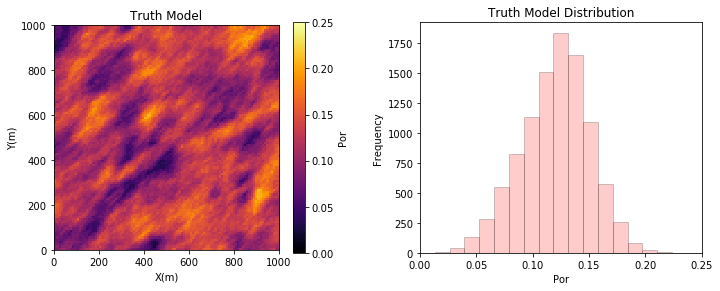

In [164]:
# Truth Model Parameters 
seed = 73073                              # random number seed for repeatable random samples and rejection sampler 
name = 'Por'                              # name of the feature of interest
mean = 0.13                               # univariate distribution mean - assuming Gaussian distribution
stdev = 0.03                              # univariate standard deviation 
nug = 0.0                                 # nugget effect - variogram model
it = 1                                    # type of structure (1 -spherical, 2 - exponential, 3 - Gaussian)
azi = 45.0                                # primary direction/azimuth of continuity (0 = y positive, 90 = x positive)
hmaj = 800                                # variogram range in the major direction
hmin = 300                                # variogram range in the minor direction (major direction + 90)

# Make the variogram object
vario = GSLIB.make_variogram(nug,nst=1,it1=it,cc1=1.0,azi1=azi,hmaj1=hmaj,hmin1=hmin) # make model object

# Make the dummy dataset (should be outside the range of correlation of the model)
df = pd.DataFrame({'X':np.full(100,-9999),'Y':np.full(100,-9999),name:np.random.normal(0.0,1.0,100)})

# Truth Model Grid Parameters
nx = 100; ny = 100                        # number of cells in the x and y directions
xsiz = 10.0; ysiz = 10.0                  # size of the cells in the x and y directions
xmn = xsiz * 0.5; ymn = ysiz * 0.5        # assume origin at 0,0, calculate the 1 cell centroid
xmin = xmn - 0.5*xsiz; ymin = ymn - 0.5*ysiz # assume origin at 0,0, calculate the min and max x/y coordinates
xmax = xmin + nx * xsiz; ymax = ymin + ny * ysiz;
vmin = 0.0; vmax = 0.25                   # feature min and max for color bars

# Calculate the Simulated Truth Model over the Specified Grid and Variogram 
sim_ns = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

# Apply Affine Correction to adjust the standard normal distribution to the target mean and standard deviation 
sim = GSLIB.affine(sim_ns,.12,0.03)
cmap = plt.cm.inferno

# Visualize the Truth Model Map and Histogram
plt.subplot(121)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Truth Model')  
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(sim,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
cbar = plt.colorbar()
cbar.set_label(name)

plt.subplot(122)
plt.hist(sim.flatten(),bins = np.linspace(vmin,vmax,20),alpha=0.2,color="red",edgecolor="black")
plt.xlim([vmin,vmax])
plt.title('Truth Model Distribution')
plt.xlabel(name); plt.ylabel('Frequency')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.3, hspace=0.3)
plt.show()

#### Sample from the Truth Model

The following sampling workflow includes the following steps:

1. Apply Regular Sampling
2. Apply Random Sampling
3. Combine the Regular and Random Samples
4. Apply Rejection Sampling to Impose Bias
5. Remove Spatial Duplicates 

We check for and remove spatial duplicates, while each step will not produce duplicates (samples coincidental in space), this is a low probability of this occuring between steps.

* spatial duplicates cause analysis issues such as singular matrices for kriging etc.

You can adjust the following parameters to customize your sample set:

* **spacing** - the interwell spacing in x and y of the regular samples
* **nrandom_sample** - the number of random samples
* **wt_min** - the relative weight of the lowest value - linear interpolation is applied between min and max values
* **wt_max** - the relative weight of the highest value
* **bias_frac** -the proportion of the dataset to reject

Some other ideas:

* limit the regular and random samples to subsets of the truth model (use minsx,maxsx,minsy,maxsy)
* use multiple regular sample sets over different parts of the truth model
* use multiple random sample sets over different parts of the truth model with different sampling densities
* change the random number seed to get multiple datasets with the same sampling parameters

With the provided operations there is a lot of flexibility to build a unique sample set. The following workflow is a simple demonstration:

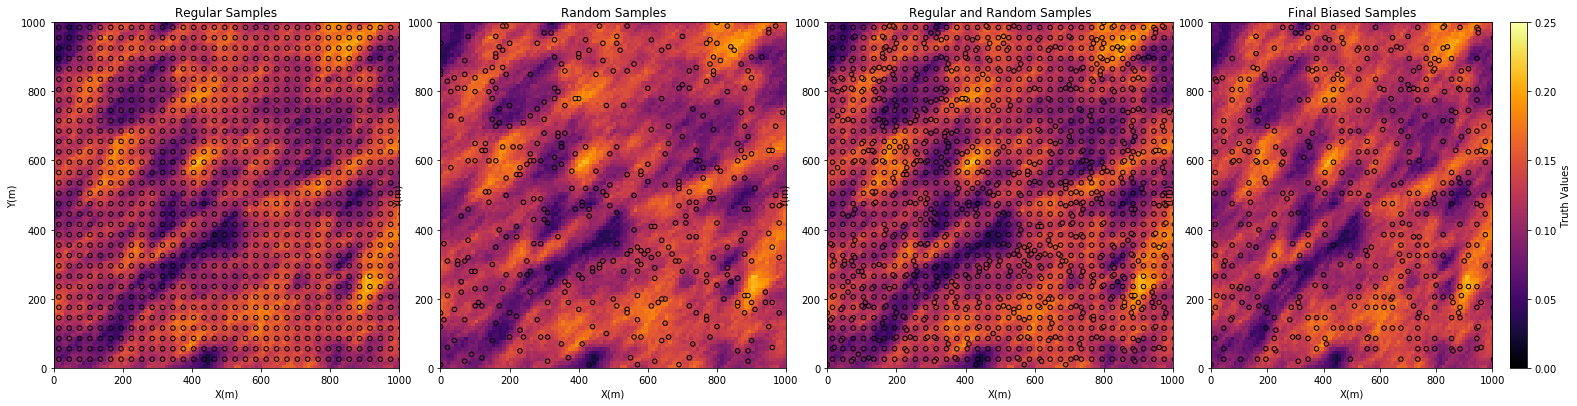

In [177]:
# Data Set Sampling Paramters
spacing = 30                              # spacing of regular samples
nrandom_sample = 400                      # number of random samples
wt_min = 0.1; wt_max = 1.0                # weigths of minimum and maximum feature values - control on degree of bias 
bias_frac = 0.7                           # fration of dataset to remove with rejection sampler
seed = 73073                              # random number seed

np.random.seed(seed = seed)               # set the random number seed for repeatability of samples

# Regular Sampling
regular_samples = regular_sample(sim,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,spacing=spacing,
                         minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name=name)

# Random Sampling
random_samples = random_sample(sim,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                                     nsamp = nrandom_sample,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name = name)

# Concatenate (Combine) Regular and Random Samples into One DataFrame  
samples = pd.concat([regular_samples,random_samples])

# Rejection Sampler
biased_samples = rejection_sample(samples,name,1-bias_frac,wt_min,wt_max)

# Remove Dupicates 
biased_samples = biased_samples[np.invert(biased_samples.duplicated(subset=['X','Y'],keep='first'))] 

# Visualize Each Step of the Process and the Final Sample Set and Truth Model
plt.subplot(141)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Regular Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(sim,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(regular_samples['X'],regular_samples['Y'],c = regular_samples[name],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Regular Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(142)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Random Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(sim,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(random_samples['X'],random_samples['Y'],c = random_samples[name],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Random Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(143)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Regular and Random Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(sim,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(samples['X'],samples['Y'],c = samples[name],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Regular and Random Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(144)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Final Biased Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(sim,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples[name],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar()
cbar.set_label('Truth Values')
ax4.set_aspect('auto')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.1, hspace=0.2)
plt.show()    

#### Save the Truth Model and Sample Data

Now we finish up by saving the truth model and sample data. 

* sample data DataFrame (biased_sample) will be saved to a '.csv'

* truth model (sim) will be saved to a 

More information and examples for loading and saving data with [DataFrames](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_DataFrame.ipynb) and [ndarrays](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_ndarrays.ipynb).

We will complete the following steps:

1. set the working directory, target for the saved files

2. save the sample set 

3. save the truth model

In [178]:
# Set the Working Directory
os.chdir('D:\Courses')  

# Save the Sample Set
biased_samples.to_csv(name + "_sample.csv")
#load_samples_test = pd.read_csv(name + "_sample.csv") # uncomment to test loading back in the saved sample set

# Save the Truth Model
np.savetxt(name + "_truth_map.csv", sim, delimiter=",")
#load_truth_model_test = np.loadtxt(name + "_truth_map.csv", delimiter=",") # uncomment to test loading back in the saved truth model

#### Comments

This was a basic workflow for generating a 2D spatial truth model and an associated sample set. I hope this is useful for education, demonstrations and research.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. Also, I have posted a lot of other example workflows and source code to help you get learn about and get work done with **Spatial Data Analytics, Geostatistics and Machine Learning** in Python and R. Check out the [GeostatsGuy Inventory](https://github.com/GeostatsGuy/Resources) and I have a [YouTube](https://youtube.com/GeostatsGuyLectures) channel with all my university lectures recorded.
  
I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)